In [5]:
import datetime
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


# augmentation
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32
)


model = Sequential()
model.add(Flatten(input_shape=(128, 128, 3), name="flatten-layer"))
model.add(Dense(units=64, activation='relu', name="hidden-layer"))
model.add(Dense(units=2, activation='sigmoid', name="output-layer"))

plot_model(model, to_file='./img/logistic-regression-with-hidden-layer.png', show_shapes=True, show_layer_names=True)


model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["acc"])


log_dir = "logs/fit/test-logistic-regression-with-hidden" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(histogram_freq=1, write_graph=True, write_grads=True, log_dir=log_dir)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


history = model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=20,
    validation_data=val_generator,
    # validation_split=0.01
    callbacks=[reduce_lr, tb]
)

# model.evaluate(test_generator)

model.save('masknet-logistic-regression-with-hidden.h5')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/20
9/9 [==============================] - 7s 761ms/step - loss: 8.0367 - acc: 0.5590 - val_loss: 3.6786 - val_acc: 0.5000
Epoch 2/20
9/9 [==============================] - 6s 720ms/step - loss: 2.5820 - acc: 0.5729 - val_loss: 1.2441 - val_acc: 0.7775
Epoch 3/20
9/9 [==============================] - 7s 807ms/step - loss: 0.8526 - acc: 0.7951 - val_loss: 0.9341 - val_acc: 0.8025
Epoch 4/20
9/9 [==============================] - 8s 864ms/step - loss: 0.6619 - acc: 0.8438 - val_loss: 0.5503 - val_acc: 0.8238
Epoch 5/20
9/9 [==============================] - 8s 846ms/step - loss: 0.3950 - acc: 0.9007 - val_loss: 0.4749 - val_acc: 0.8662
Epoch 6/20
9/9 [==============================] - 8s 904ms/step - loss: 0.3511 - acc: 0.9028 - val_loss: 0.4052 - val_acc: 0.8850
Epoch 7/20
9/9 [==============================] - 8s 835ms/step - loss: 0.3957 - acc: 0.8819 - 

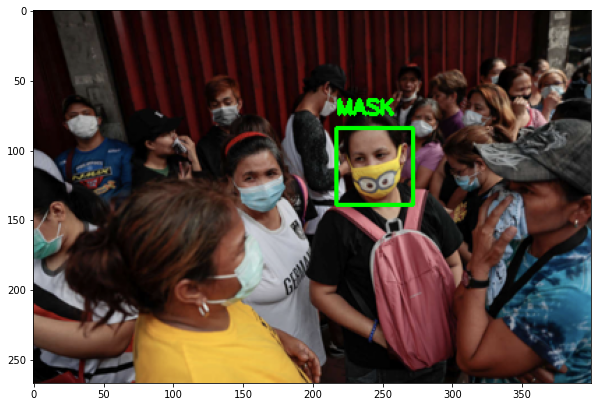

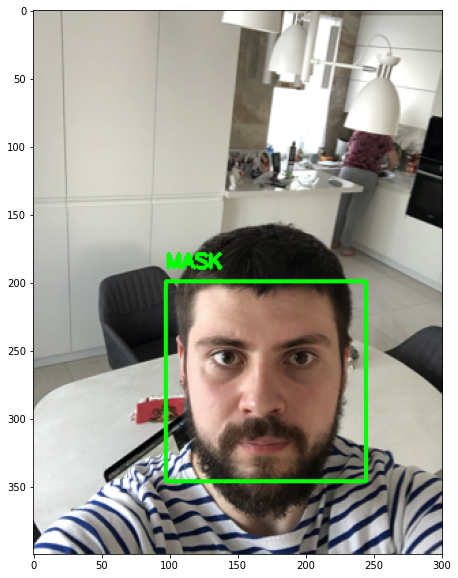

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier(
    '../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')
model = load_model('masknet-logistic-regression-with-hidden.h5')
mask_label = {0: 'MASK', 1: 'NO MASK'}
color_label = {0: (0, 255, 0), 1: (255, 0, 0)}
def detect(image_id):
    # Read in an image
    img = cv2.imread(f'../input/face-mask-detection/images/maksssksksss{image_id}.png')
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    # Detect faces
    faces = face_model.detectMultiScale(img)
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        crop = new_img[y:y + h, x:x + w]
        crop = cv2.resize(crop, (128, 128))
        crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
        mask_result = model.predict(crop)
        color = color_label[mask_result.argmax()]
        cv2.putText(
            new_img,
            mask_label[mask_result.argmax()],
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            2
        )
        cv2.rectangle(new_img, (x, y), (x+w, y+h), color, 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(new_img)

detect('331')
detect('455')